In [36]:
import matplotlib.pyplot as plt
from datetime import datetime


def format_data(N_hours):
    full_data = []
    for i in range(N_hours+1):
        filename = str(i) + ".txt"

        file = open(filename, 'r')

        rows = file.readlines()
        data = []
        for row in rows:
            new_data = row[0:len(row)-1].split("\t")
            new_data[0] = int(new_data[0])
            new_data[1] = datetime.fromisoformat(new_data[1][0:len(new_data[1])-1])
            new_data[2] = int(new_data[2])
            new_data[3] = float(new_data[3])
            new_data[4] = float(new_data[4])
            data.append(new_data)

        #for row in data:
        #print(len(data))
        full_data += data
        file.close()

    #full_data = full_data[0:len(full_data)]
    #print(len(full_data))
    #for i in range(44680, 44710, 1):
    #    print(full_data[i])
    return full_data

full_data = format_data(43)


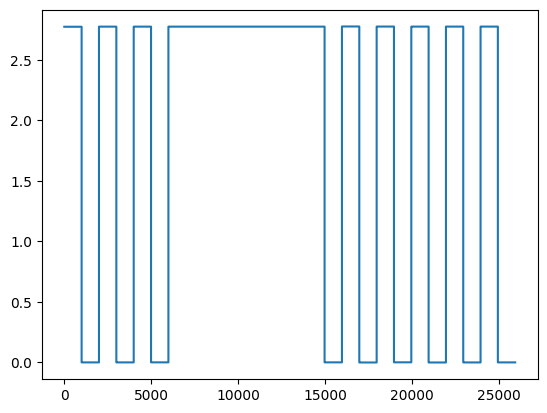

In [37]:
#Analizando el glitch en particular

glitch_data = full_data[44690:44710]

v = []
t = []
for i in range(1, len(glitch_data)):
    if i == 1:
        base_t = 0    
    else:
        base_t = t[-1]
    for j in range(base_t, base_t + glitch_data[i][2]+1):
        t.append(j)
        v.append(glitch_data[i][3])

plt.plot(t,v)
plt.show()

In [38]:
import numpy as np
#Analisis de precision del clock

#Obtain all possible Vcc values with 0.1 difference
v_list = []

for data in full_data:
    v_high = max(data[3], data[4])
    v_high = float(str(v_high)[:3])
    if not v_high in v_list:
        v_list.append(v_high)
v_list.sort(reverse=True)

#Get a list, each row is a list of ms period for that Voltage

total_period_by_v = [[]]
nominal_period_by_v = [[]]
outliers_by_v = [[]]

current_v_high = 0
for data in full_data:
    v_high = max(data[3], data[4])
    v_high = float(str(v_high)[:3])
    if v_high == current_v_high:
        total_period_by_v[-1].append(data[2])
        if abs(data[2]-1000) < 20:           #Tolerancia del 2% del valor nominal de 1000useg
            nominal_period_by_v[-1].append(data[2])
        else:
            outliers_by_v[-1].append(data[2])
    else:
        total_period_by_v.append([data[2]])
        if abs(data[2]-1000) < 20:           #Tolerancia del 2% del valor nominal de 1000useg
            nominal_period_by_v.append([data[2]])
            outliers_by_v.append([])
        else:
            nominal_period_by_v.append([])
            outliers_by_v.append([data[2]])
        current_v_high = v_high

total_period_by_v = total_period_by_v[1:]
nominal_period_by_v = nominal_period_by_v[1:]
outliers_by_v = outliers_by_v[1:]


for i in range(len(total_period_by_v)):
    print("V = ", v_list[i], "V")
    #print("\ttotal_period_by_v = ", total_period_by_v[i])
    #print("\tlen(total_period_by_v) = ", len(total_period_by_v[i]))
    #print("")
    #print("\tlen(nominal_period_by_v) = ", len(nominal_period_by_v[i]))
    #print("")
    print("\tMean = ", np.mean(nominal_period_by_v[i]))
    print("\tStd = ", np.std(nominal_period_by_v[i]))
    print("\tPercentage of periods within a 2% from nominal: ", 100*len(nominal_period_by_v[i])/len(total_period_by_v[i]), "\%")
    #print("")
    print("\tmax, min (nominal) = ", max(nominal_period_by_v[i]), ",", min(nominal_period_by_v[i]))
    print("\tmax, min (outliers) = ", max(outliers_by_v[i]), ",", min(outliers_by_v[i]))
    #print("\toutliers_by_v = ", outliers_by_v[i])
    #print("\tlen(outliers_by_v) = ", len(outliers_by_v[i]))
    print("")
#plt.hist(total_period_by_v[1], 10000, density=False)
##plt.show(#)



V =  3.2 V
	Mean =  996.3377928242737
	Std =  1.6204841251401518
	Percentage of periods within a 2% from nominal:  99.90569545071227 \%
	max, min (nominal) =  1018 , 985
	max, min (outliers) =  8761 , 222

V =  2.9 V
	Mean =  985.8240282339101
	Std =  1.4358709803697167
	Percentage of periods within a 2% from nominal:  99.85072070087854 \%
	max, min (nominal) =  1018 , 981
	max, min (outliers) =  1270 , 700

V =  2.7 V
	Mean =  1003.3703573931324
	Std =  1.336713044879655
	Percentage of periods within a 2% from nominal:  98.17681458548331 \%
	max, min (nominal) =  1013 , 982
	max, min (outliers) =  1748 , 259

V =  2.0 V
	Mean =  998.7831290134268
	Std =  1.2145576475933593
	Percentage of periods within a 2% from nominal:  99.30434782608695 \%
	max, min (nominal) =  1010 , 990
	max, min (outliers) =  1459 , 541



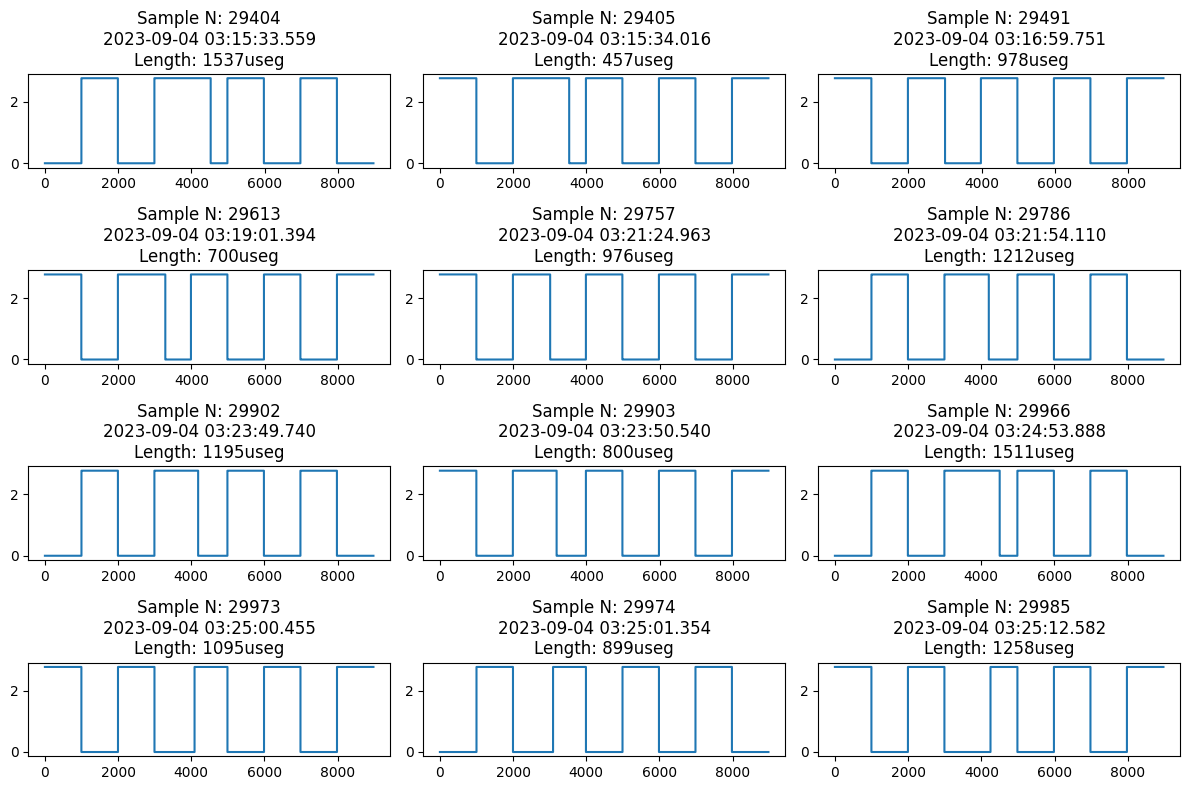

In [39]:
#Time analysis of glitches:

#Outliers is a list of lists of data points, where each list is 10 points of data, centered around an outlier
outliers = []
for i in range(len(full_data[5:-5])):
    if abs(full_data[i][2]-1000) > 20:           #Tolerancia del 2% del valor nominal de 1000useg
        outliers.append(full_data[i-4:i+6])

#Transform Outliers elements to time series data
outliers_timeseries = []
for p in range(len(outliers)):
    v = []
    t = []
    for i in range(1, len(outliers[p])):
        if i == 1:
            base_t = 0    
        else:
            base_t = t[-1]
        for j in range(base_t, base_t + outliers[p][i][2]+1):
            t.append(j)
            v.append(outliers[p][i][3])
    outliers_timeseries.append([t, v, outliers[p][4][1], outliers[p][4][0], outliers[p][4][2]])        #Now each element in outliers is a timeseries shifted to t=0, we should also add the moment when it happened, so whe add the timestamp of the outlier (number 4 in timeseries)

cols = 3
rows = 4

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))

# Create your plots and add them to the grid
for i in range(rows):
    for j in range(cols):
        # Create your plot here (e.g., using plt.plot(), plt.scatter(), etc.)
        # Example:
        axes[i, j].plot(outliers_timeseries[j+rows*i][0], outliers_timeseries[j+rows*i][1])
        axes[i, j].set_title("Sample N: " + str(outliers_timeseries[j+rows*i][3]) + "\n" + str(outliers_timeseries[j+rows*i][2])[:-3] + "\nLength: " + str(outliers_timeseries[j+rows*i][4]) + "useg")
        # You can customize the individual plots here

# Adjust layout and spacing
plt.tight_layout()

# Show or save the plot
plt.show()



146
92


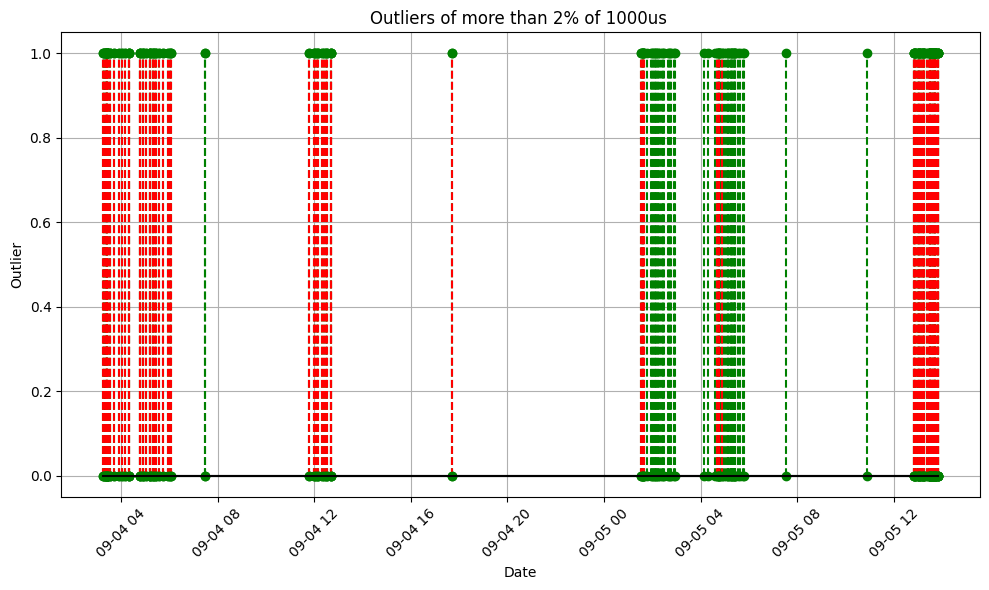

In [40]:
#Timewise plot of different outliers
dates = []
true_outlier = []
possible_glitch = []
for i in range(len(outliers)):
    dates.append(outliers[i][4][1])
    if i+1 < len(outliers):
        if outliers[i][4][0] + 1 == outliers[i+1][4][0] and ((outliers[i][4][2] + outliers[i+1][4][2])/2 - 1000 < 20):    #Subsecuent outliers with sum close to 2 times 1000useg get categorized as possible computer glitch
            true_outlier.append(0)
            possible_glitch.append(1)
        else:
            true_outlier.append(1)
            possible_glitch.append(0)
    else:
        true_outlier.append(1)
        possible_glitch.append(0)

print(true_outlier.count(1))
print(possible_glitch.count(1))

plt.figure(figsize=(10, 6))  # Set the figure size

# Plot using datetime as the x-axis
plt.stem(dates, true_outlier, linefmt='g--', markerfmt='go', basefmt='k', label='True Outliers')
plt.stem(dates, possible_glitch, linefmt='r--', markerfmt='go', basefmt='k', label='Possible Computer Glitch')

# You can customize the plot here (labels, titles, etc.)
plt.xlabel('Date')
plt.ylabel('Outlier')
plt.title('Outliers of more than 2% of 1000us ')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

  



